In [1]:

# Pytorch - for build and train network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", ComplexWarning)
#     # Your code using SciPy here

# for the classifiers also the cluster.
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# for the classification evaluation.
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# handel the imbalanced dataset us  SMOTE method
from imblearn.over_sampling import SMOTE
from collections import Counter

from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.notebook import tqdm

import pickle
import math

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re

import os
# cwd = os.getcwd()

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# get the path of the folder.

cwd = os.getcwd()

df = pd.read_excel(cwd+'/tamedia 1000 transcripts to label 2024-06-08.xlsx', index_col=0)
# df.head()

### Clean data

In [4]:
# Define a function to split, expand motive types, and remove probabilities
def split_and_expand_motive_types(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == 'Keine' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    matches = re.findall(r'(\w+)\s*\(\d*\.?\d*\)', text)  # Extract just the motive name, ignoring the probability
    if matches:
        # Generate a new row for each motive type without the probability
        expanded_rows = []
        for match in matches:
            new_row = row.copy()
            new_row['motive_final'] = match  # Set the motive name without the probability
            expanded_rows.append(new_row)
        return expanded_rows
    else:
        return [row]  # Return the original row if no matches found

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types(row)])
df = expanded_df

df = df[['motive_final', 'textAno4']]
df['motive_final'] = df['motive_final'].fillna('0')
df['motive_final'] = df['motive_final'].replace('Keine ', 'Keine')
df['motive_final'] = df['motive_final'].replace('Abgabe  ', 'Abgabe')
df['motive_final'] = df['motive_final'].replace('Preisoptimierer', 'Preisoptimierung')

# print (df['motive_final'].unique())

# Define a function to split, expand motive types, and handle specific cases
def split_and_expand_motive_types2(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == '0' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    expanded_rows = []

    # Handle the specific case "Selbermachen 0.5, Ratsuche 0.5"
    if text == 'Selbermachen 0.5, Ratsuche 0.5':
        motives = ['Selbermachen', 'Ratsuche']
    # Handle the specific case "0.5 Selbermachen, 0.5 n/a"
    elif text == '0.5 Selbermachen, 0.5 Keine':
        motives = ['Selbermachen', 'Keine']
    else:
        # Generic handling: Extract motive names without probabilities
        motives = re.findall(r'(\w+)\s*\d*\.?\d*', text)

    # Generate a new row for each motive name without the probability
    for motive in motives:
        new_row = row.copy()
        new_row['motive_final'] = motive  # Set the motive name without the probability
        expanded_rows.append(new_row)

    return expanded_rows

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types2(row)])

df = expanded_df

# Replace '\n' with ' ' in the 'textAno4' column
df['textAno4'] = df['textAno4'].str.replace('\n', ' ')



# Extract unique placeholders
unique_placeholders = set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4'])))
print(unique_placeholders)

# Extract unique speaker identifiers
unique_speakers = set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4'])))
print(unique_speakers)


translations = {}

# Translate each placeholder
translations[' street { street name '] = 'Strassenname'
translations[' street name '] = 'Strassenname'
translations[' number '] = 'Nummer'
translations[' address '] = 'Adresse'
translations[' { e-mail '] = 'E-Mail'
translations[' e-mail '] = 'E-Mail'
translations['name'] = 'Name'
translations[' town '] = 'Stadt'

# Translate each speaker
translations['SPEAKER_A'] = 'SPRECHER_A'
translations['SPEAKER_B'] = 'SPRECHER_B'
translations['SPEAKER_C'] = 'SPRECHER_C'
translations['SPEAKER_D'] = 'SPRECHER_D'
translations['SPEAKER_UNKNOWN'] = 'SPRECHER_UNBEKANNT'

# Replace placeholders in DataFrame
for eng_placeholder, ger_translation in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_placeholder, ger_translation)

# Replace speakers in DataFrame
for eng_speaker, ger_speaker in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_speaker, ger_speaker)

print (set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4']))))
print (set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4']))))
df.head()

{' { e-mail ', ' street { street name ', ' number ', ' town ', 'name', ' street name ', ' address ', ' e-mail '}
{'SPEAKER_B', 'SPEAKER_A', 'SPEAKER_D', 'SPEAKER_C', 'SPEAKER_UNKNOWN'}
{'Name', 'Nummer', 'StrassenName', 'Adresse', 'Stadt', 'E-Mail'}
{'SPRECHER_D', 'SPRECHER_B', 'SPRECHER_C', 'SPRECHER_A', 'SPRECHER_UNBEKANNT'}


,motive_final,textAno4
1,Ratsuche,"SPRECHER_A : Ich glaube , bei der Berner Zeitu..."
1,Vertrauen,"SPRECHER_A : Ich glaube , bei der Berner Zeitu..."
2,Keine,"SPRECHER_B : Berner Zeitung , Aboservice , {Na..."
3,Preisoptimierung,SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4,Vertrauen,"SPRECHER_A : Schweizer Familie , Aboservice , ..."


In [5]:



repl = ['SPEAKER','SPEAKER_','SPEAKER_A','SPEAKER_B','Speaker', 'Sprecher_A','Sprecher_B','Sprecher_C','Sprecher_D','Sprecher_Unbekannt',
        'SPRECHER_A','SPRECHER_B','SPRECHER_C','SPRECHER_D','SPRECHER_UNBEKANNT']

def cleanTextDF(df, column):
    """Clean text in the specified column."""
    df['textClean'] = df[column].fillna('').astype(str)  # Ensure no NaN values and convert to string
    df['textClean'] = df['textClean'].str.replace(r'\d+', '', regex=True)  # Remove numbers
    # Remove anonymisation placeholders
    df['textClean'] = df['textClean'].str.replace(r'({Name}|{Nummer}|Strassenummer|{Stadt}|{Ort})', '', regex=True)
    # Remove punctuation except fullstop
    df['textClean'] = df['textClean'].str.replace(r'[,{}?!:;]', '', regex=True)
    # Remove apostrophes
    df['textClean'] = df['textClean'].str.replace(r"[\"\',]", '', regex=True)
    df['textClean'] = df['textClean'].apply(lambda x: ' '.join([word for word in x.split() if word not in repl]))

    return df['textClean']

df['textClean'] = cleanTextDF(df, 'textAno4')
df.columns

Index(['motive_final', 'textAno4', 'textClean'], dtype='object')

In [6]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Function to count tokens in a text
def count_tokens(text):
    tokens = word_tokenize(text)  # Tokenize text using NLTK's word_tokenize
    return len(tokens)

# Apply count_tokens function to 'text' column and find maximum
print (df['textClean'].apply(count_tokens).min())
print (df['textClean'].apply(count_tokens).max())

[nltk_data] Downloading package punkt_tab to /Users/kai/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


25
3586


In [7]:

df.rename(columns={'textClean': 'text','motive_final':'label'}, inplace = True)

unique_labels = df['label'].unique()

# Create a label encoder
label_encoder = {label: i for i, label in enumerate(unique_labels)}

# Encode the labels
df['label_encoded'] = df['label'].map(label_encoder)

df = df[['label','text','label_encoded']]
df.head()

,label,text,label_encoded
1,Ratsuche,Ich glaube bei der Berner Zeitung würde ich Ih...,0
1,Vertrauen,Ich glaube bei der Berner Zeitung würde ich Ih...,1
2,Keine,Berner Zeitung Aboservice mein Name wie kann i...,2
3,Preisoptimierung,Finanz und Wirtschaft . Mein Name ist Poguca R...,3
4,Vertrauen,Schweizer Familie Aboservice mein Name wie kan...,1


In [8]:
df[df['label'] != '0'].shape,  df[df['label'] == '0'].shape ,df[df['label_encoded'] != 8].shape,  df[df['label_encoded'] == 8].shape

((416, 3), (665, 3), (416, 3), (665, 3))

In [9]:
# remove multilabed text
df = df.drop_duplicates(subset='text', keep="first")
print(df.head())

              label                                               text  \
1          Ratsuche  Ich glaube bei der Berner Zeitung würde ich Ih...   
2             Keine  Berner Zeitung Aboservice mein Name wie kann i...   
3  Preisoptimierung  Finanz und Wirtschaft . Mein Name ist Poguca R...   
4         Vertrauen  Schweizer Familie Aboservice mein Name wie kan...   
5         Vertrauen  Guten Tag hier ist von der Passer-Zeitung . Ja...   

   label_encoded  
1              0  
2              2  
3              3  
4              1  
5              1  


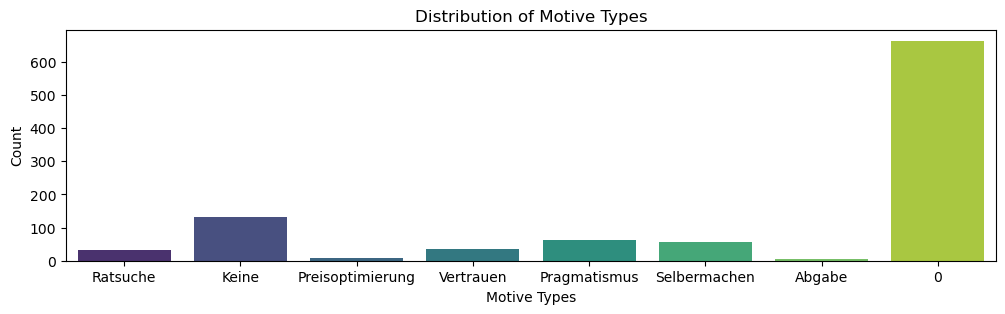

Counter({'0': 664,
         'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33,
         'Preisoptimierung': 9,
         'Abgabe': 5})

In [10]:
plt.figure(figsize=(12, 3))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()
Counter(df.label)

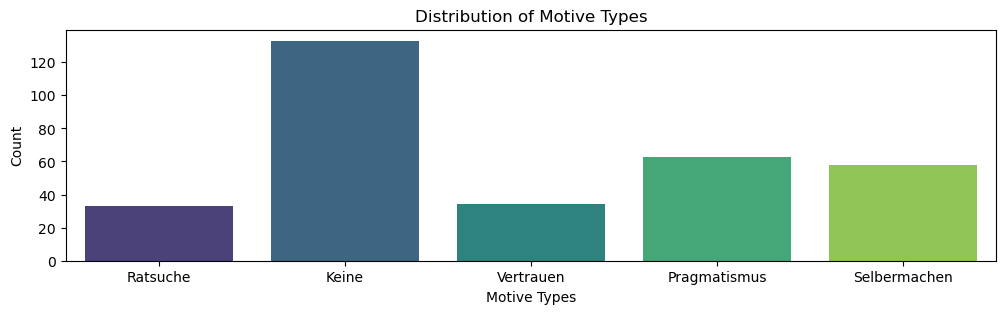

In [11]:
df_l = df[df['label'] != "0"]
df_l = df_l[df_l['label'] != 'Abgabe']
df_l = df_l[df_l['label'] != 'Preisoptimierung']
df_ul = df[df['label'] == "0"]
# Counter(df_ul.label)
plt.figure(figsize=(12, 3))
sns.countplot(x='label', data=df_l, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()

## Binary

In [12]:
binary_df = df_l.copy()
for i in df_l['label_encoded'].unique():
    binary_df[f'label_{i}'] = binary_df['label_encoded'].apply(lambda x: 1 if x == i else 0)

binary_df.head()

,label,text,label_encoded,label_0,label_2,label_1,label_5,label_6
1,Ratsuche,Ich glaube bei der Berner Zeitung würde ich Ih...,0,1,0,0,0,0
2,Keine,Berner Zeitung Aboservice mein Name wie kann i...,2,0,1,0,0,0
4,Vertrauen,Schweizer Familie Aboservice mein Name wie kan...,1,0,0,1,0,0
5,Vertrauen,Guten Tag hier ist von der Passer-Zeitung . Ja...,1,0,0,1,0,0
6,Pragmatismus,Also sagen wir nochmals einen schönen guten Ta...,5,0,0,0,1,0


In [13]:
# RESET split train and test

binary_label = [f'label_{i}' for i in binary_df['label_encoded'].unique()]
X_l = binary_df.text
y_l = binary_df[binary_label]
X_ul = df_ul.text


###  Vectorize - TFIDF


In [14]:
# vectorize

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words=None,
)
t0 = time()
X_l_tfidf = vectorizer.fit_transform(X_l)
X_ul_tfidf = vectorizer.fit_transform(X_ul)


print(f"n_samples: {X_l_tfidf.shape[0]}, n_features: {X_l_tfidf.shape[1]}")

n_samples: 321, n_features: 838


In [15]:


# LSA feature reduction.
lsa = make_pipeline(TruncatedSVD(n_components=80), Normalizer(copy=False))
t0 = time()
X_l_lsa = lsa.fit_transform(X_l_tfidf)
X_ul_lsa = lsa.fit_transform(X_ul_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.102 s
Explained variance of the SVD step: 43.9%


In [16]:
binary_df.label_encoded.unique()

array([0, 2, 1, 5, 6])

In [17]:
X_ul = X_ul_lsa
env_input = []

for i in binary_df.label_encoded.unique():
    # split the training(labeled) as 50% of  labeled dataset
    X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l_lsa, y_l[f'label_{i}'], test_size=0.5, random_state=4)
    # SMOTE rebanlance the label
    if sum(y_l_train) < 5:
        sm = SMOTE(random_state=42, k_neighbors=sum(y_l_train)-1)
    else:
        sm = SMOTE(random_state=42)
    X_l_train, y_l_train = sm.fit_resample(X_l_train, y_l_train)
    env_input.append([ X_l_train, X_l_test, y_l_train, y_l_test])


In [35]:
for inpute_data in env_input:
    print(Counter(inpute_data[3]))

Counter({0: 144, 1: 17})
Counter({0: 96, 1: 65})
Counter({0: 142, 1: 19})
Counter({0: 132, 1: 29})
Counter({0: 130, 1: 31})


# Data prepare for RLCO

In [18]:

# Initialize classifiers (KNN and SVM)
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
classifiers = [knn, svm]

In [19]:
# define ENV

# for clustering the unlabeld data



class Env():
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__
        self.models = classifiers

        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # update 2 clf
    def train_2_clf(self, X, y):
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self, reset=False):
        """
        Generate a state representation by predicting probabilities on centroids using stored models.
        Optionally resets and retrains models using X_reset and y_reset.

        :param reset: Boolean flag to reset and retrain models before prediction.
        :return: Torch tensor of concatenated probabilities reshaped as (1, -1).
        """
        if reset:
            if self.X_reset is not None and self.y_reset is not None:
                self.train_2_clf(self.X_reset, self.y_reset)
            else:
                raise ValueError("Reset datasets X_reset or y_reset are not provided.")

        if not hasattr(self, 'models') or len(self.models) < 2:
            raise ValueError("Model list is incomplete or not set.")

        try:
            out_1 = self.models[0].predict_proba(self.centroids)
            out_2 = self.models[1].predict_proba(self.centroids)
            out_1 = np.asarray(out_1)
            out_2 = np.asarray(out_2)
            state_proba = np.concatenate((out_1, out_2), axis=1)
        except Exception as e:
            raise RuntimeError(f"Model prediction failed: {e}")
        
        if not isinstance(state_proba, np.ndarray):
            raise TypeError(f"Expected numpy.ndarray, got {type(state_proba)}")
        
        state_proba = np.asarray(state_proba)  # Ensure it's a plain ndarray
        return torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)



        #####
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in [self.models[0], self.models[1]]]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in [self.models[0], self.models[1]]],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        f1_macro = f1_score(self.y_eval, combined_predictions, average='macro')
        f1_micro = f1_score(self.y_eval, combined_predictions, average='micro')

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_macro)
        micro_f1 = np.mean(f1_micro)
        return macro_f1, micro_f1

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset):

        # Average class probabilities across classifiers
        avg_probabilities = np.mean([clf.predict_proba(subset) for clf in self.models], axis=0)

        # Assign the label with the highest average probability
        y_ul_action = np.argmax(avg_probabilities, axis=1)
        # print(y_ul_action)

        ########### update the label_set for traning
        X_updated = np.concatenate((self.X_reset, subset), axis=0)
        y_updated = np.concatenate((self.y_reset, y_ul_action), axis=0)

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_updated, y_updated)


        return self.get_f1()

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        macrof1, microf1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)


        # cotraining the 2 classifier
        new_marco_f1, new_micro_f1 = self.co_training(choosen_subset)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > macrof1:
            reward_0 = new_marco_f1 - macrof1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1, new_micro_f1


In [20]:
len(env_input)

5

In [21]:
k = 300
envs = []
for i in range(len(env_input)):
    envs.append(Env(classifiers, input_ul_data=X_ul, k=k, X_reset=env_input[i][0], X_test=env_input[i][1], y_reset=env_input[i][2], y_test=env_input[i][3]))


In [22]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor: outputs action probabilities (softmax)
        self.actor = nn.Linear(128, action_size)


        # Critic: outputs state value (for advantage calculation)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Policy (actor): softmax over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Value (critic): state value estimation
        state_value = self.critic(x)

        return action_probs, state_value

In [23]:
# Assuming the ActorCritic class and environment 'env' are properly defined
# Create an instance of the ActorCritic network
actor_critic_networks = []
optimizers = []
for i in range(len(envs)):
    actor_critic_networks.append(ActorCritic(envs[i].observation_size, envs[i].action_size))
    # actor_critic = ActorCritic(env.observation_size, env.action_size)
    optimizers.append(optim.Adam(actor_critic_networks[i].parameters(), lr=0.001))

# Training parameters
num_episodes = 200
gamma = 0.99
results = []

In [24]:
for i in range(len(envs)):
    # Training parameters
    #track scores
    episode_rewards = []
    episode_f1s = []
    macro_f1_scores = []
    micro_f1_scores = []
    # Main training loop
    for episode in tqdm(range(num_episodes)):
        state = envs[i].get_state(reset=True)
        # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
        episode_reward = 0

        for t in range(1, 200):  # Limit the number of time steps
            # No need to use GradientTape; PyTorch handles gradients automatically
            # Choose an action using the actor
            action_probs, state_value = actor_critic_networks[i](state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()


            # Take the chosen action and observe the next state and reward
            next_state, reward, macro_f1, micro_f1 = envs[i].step(action.item())
            next_state = torch.FloatTensor(next_state).unsqueeze(0)

            # Compute the advantage
            # _, state_value = actor_critic(state)
            _, next_state_value = actor_critic_networks[i](next_state)
            advantage = reward + gamma * next_state_value - state_value

            # Compute actor and critic losses
            actor_loss = -dist.log_prob(action) * advantage.detach()
            critic_loss = advantage.pow(2)

            # Combine losses for joint update
            total_loss = actor_loss + critic_loss

            # Update actor and critic
            optimizers[i].zero_grad()
            total_loss.backward()
            optimizers[i].step()

            state = next_state
            episode_reward += reward
            episode_f1s.append(macro_f1)
            if episode == num_episodes - 1:
                macro_f1_scores.append(macro_f1)
                micro_f1_scores.append(micro_f1)

        episode_rewards.append(episode_reward)

        if episode % 10 == 0:
            print(f"CLASS_{i} Episode {episode}, Reward: {episode_reward}")
    results.append([episode_rewards, episode_f1s, macro_f1_scores, micro_f1_scores])

  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_0 Episode 0, Reward: 0.10321819823617923
CLASS_0 Episode 10, Reward: 0.05429990380315547
CLASS_0 Episode 20, Reward: 0.0648218626738421
CLASS_0 Episode 30, Reward: 0.1360834700684045
CLASS_0 Episode 40, Reward: 0.1168906914490227
CLASS_0 Episode 50, Reward: 0.14995183425894515
CLASS_0 Episode 60, Reward: 0.1395674113563271
CLASS_0 Episode 70, Reward: 0.14830699984557166
CLASS_0 Episode 80, Reward: 0.09969999402388102
CLASS_0 Episode 90, Reward: 0.12415850895763547
CLASS_0 Episode 100, Reward: 0.12058230673799308
CLASS_0 Episode 110, Reward: 0.1571504260918552
CLASS_0 Episode 120, Reward: 0.13428929817664204
CLASS_0 Episode 130, Reward: 0.16927023196751417
CLASS_0 Episode 140, Reward: 0.1447422605957177
CLASS_0 Episode 150, Reward: 0.13248354794653017
CLASS_0 Episode 160, Reward: 0.1516417144845757
CLASS_0 Episode 170, Reward: 0.146283255739022
CLASS_0 Episode 180, Reward: 0.17617048587114803
CLASS_0 Episode 190, Reward: 0.15512645276121378


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_1 Episode 0, Reward: 0.9845349932503709
CLASS_1 Episode 10, Reward: 0.6059289640307164
CLASS_1 Episode 20, Reward: 0.5743026878179667
CLASS_1 Episode 30, Reward: 0.9406225101634589
CLASS_1 Episode 40, Reward: 0.6562074025158499
CLASS_1 Episode 50, Reward: 0.5730477884460297
CLASS_1 Episode 60, Reward: 0.5065407925279845
CLASS_1 Episode 70, Reward: 0.4984995343443154
CLASS_1 Episode 80, Reward: 0.6168723128455842
CLASS_1 Episode 90, Reward: 0.5988022351600962
CLASS_1 Episode 100, Reward: 0.5221030278572105
CLASS_1 Episode 110, Reward: 0.5280240580021921
CLASS_1 Episode 120, Reward: 0.5280085049832792
CLASS_1 Episode 130, Reward: 0.5990178056024442
CLASS_1 Episode 140, Reward: 0.6048467557964381
CLASS_1 Episode 150, Reward: 0.5515832396483867
CLASS_1 Episode 160, Reward: 0.5930010803839753
CLASS_1 Episode 170, Reward: 0.5457031402047726
CLASS_1 Episode 180, Reward: 0.5752430369866135
CLASS_1 Episode 190, Reward: 0.5871425590637968


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_2 Episode 0, Reward: 1.2663861039256314
CLASS_2 Episode 10, Reward: 1.098064445038474
CLASS_2 Episode 20, Reward: 1.0978201732170207
CLASS_2 Episode 30, Reward: 0.880360808569493
CLASS_2 Episode 40, Reward: 1.4920724902954237
CLASS_2 Episode 50, Reward: 1.1305801625560297
CLASS_2 Episode 60, Reward: 1.0097279499672256
CLASS_2 Episode 70, Reward: 1.372336284476639
CLASS_2 Episode 80, Reward: 1.2630205724046744
CLASS_2 Episode 90, Reward: 1.350951945321655
CLASS_2 Episode 100, Reward: 1.315991667188245
CLASS_2 Episode 110, Reward: 0.9730661806500729
CLASS_2 Episode 120, Reward: 1.1143542585782504
CLASS_2 Episode 130, Reward: 1.1185837318664857
CLASS_2 Episode 140, Reward: 0.9825095871110809
CLASS_2 Episode 150, Reward: 0.9988475260477006
CLASS_2 Episode 160, Reward: 1.2418805050711437
CLASS_2 Episode 170, Reward: 1.3672064627696363
CLASS_2 Episode 180, Reward: 1.3187055417495959
CLASS_2 Episode 190, Reward: 1.2171798703517394


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_3 Episode 0, Reward: 1.487385499809578
CLASS_3 Episode 10, Reward: 1.5555253944040812
CLASS_3 Episode 20, Reward: 1.856245581413304
CLASS_3 Episode 30, Reward: 2.0407415642213698
CLASS_3 Episode 40, Reward: 2.045733042383641
CLASS_3 Episode 50, Reward: 1.3926669506363334
CLASS_3 Episode 60, Reward: 1.8704012788935325
CLASS_3 Episode 70, Reward: 0.5856334335254578
CLASS_3 Episode 80, Reward: 0.6137376636150593
CLASS_3 Episode 90, Reward: 0.6653609831254751
CLASS_3 Episode 100, Reward: 0.632413922911088
CLASS_3 Episode 110, Reward: 0.5823317374110518
CLASS_3 Episode 120, Reward: 0.667336102708269
CLASS_3 Episode 130, Reward: 1.5466630172146623
CLASS_3 Episode 140, Reward: 0.7433792073548132
CLASS_3 Episode 150, Reward: 0.7759364265626795
CLASS_3 Episode 160, Reward: 0.6765111898294949
CLASS_3 Episode 170, Reward: 0.708378769309458
CLASS_3 Episode 180, Reward: 0.7310640098746605
CLASS_3 Episode 190, Reward: 0.8015674625021505


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_4 Episode 0, Reward: 1.2342044774048309
CLASS_4 Episode 10, Reward: 0.6747106279959995
CLASS_4 Episode 20, Reward: 0.8153425514399811
CLASS_4 Episode 30, Reward: 0.773467931418989
CLASS_4 Episode 40, Reward: 0.659731475469334
CLASS_4 Episode 50, Reward: 0.7795474312288473
CLASS_4 Episode 60, Reward: 0.6955369440789181
CLASS_4 Episode 70, Reward: 0.7695863480217943
CLASS_4 Episode 80, Reward: 0.6804843580757949
CLASS_4 Episode 90, Reward: 0.8792563286793306
CLASS_4 Episode 100, Reward: 0.753049792885197
CLASS_4 Episode 110, Reward: 0.5578737048072787
CLASS_4 Episode 120, Reward: 0.7570042219899492
CLASS_4 Episode 130, Reward: 0.7610134258877184
CLASS_4 Episode 140, Reward: 0.6856225341885179
CLASS_4 Episode 150, Reward: 0.7923088110260935
CLASS_4 Episode 160, Reward: 0.7515224251008155
CLASS_4 Episode 170, Reward: 0.7672591143931723
CLASS_4 Episode 180, Reward: 0.7062786980249195
CLASS_4 Episode 190, Reward: 0.7231116156353351


In [25]:
unique_labels = binary_df['label'].unique()

In [26]:
#SAVING THE NETWORK.
import os

cwd = os.getcwd()

for i in range(5):
    # Assume `model` is your neural network
    torch.save(actor_critic_networks[i].state_dict(), cwd+f'/AC_data_binary_smote_{unique_labels[i]}.pth')



In [27]:
import json
for i in range(5):
    # results.append([episode_rewards, episode_f1s, macro_f1_scores, micro_f1_scores])
    with open(f'data_smote_{unique_labels[i]}_episode_f1s.json', 'w') as f:
        json.dump(results[i][1], f)
    with open(f'data_smote_{unique_labels[i]}_episode_r.json', 'w') as f:
        json.dump(results[i][0], f)
    with open(f'data_smote_{unique_labels[i]}_ma_f1.json', 'w') as f:
        json.dump(results[i][2], f)
    with open(f'data_smote_{unique_labels[i]}_mi_f1.json', 'w') as f:
        json.dump(results[i][3], f)

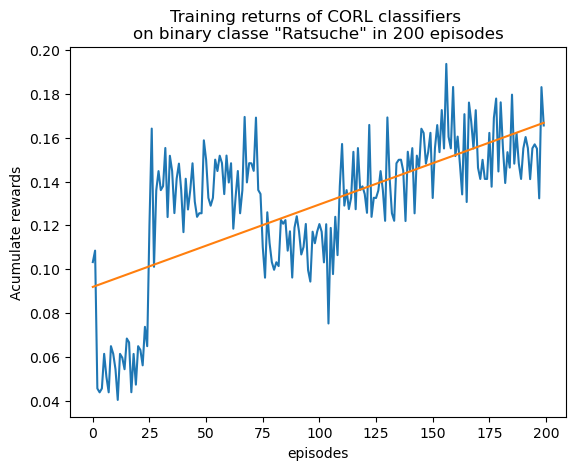

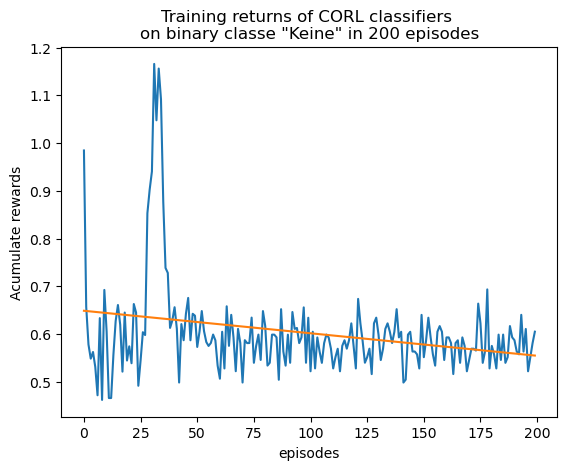

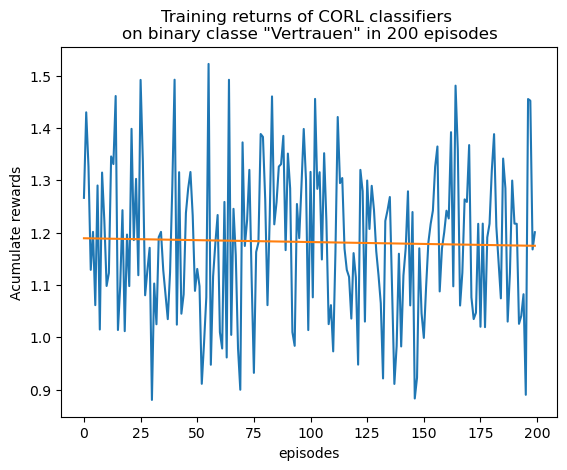

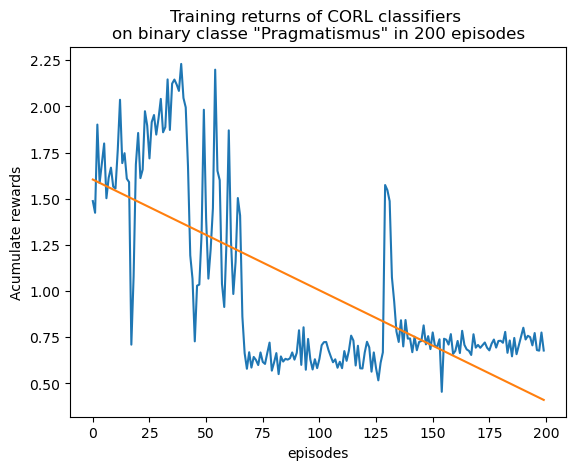

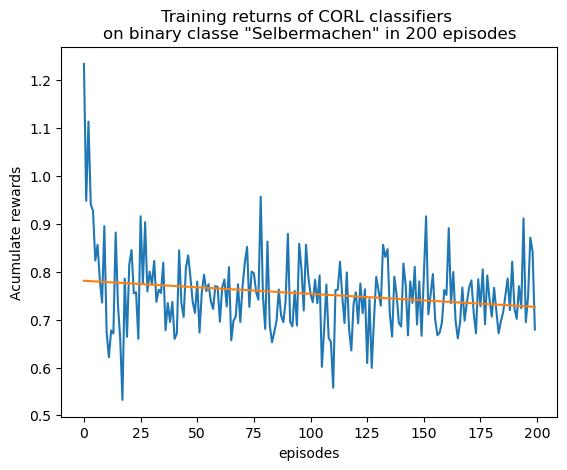

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

# PLOT THE episode rewards
for i in range(5):
    plot_data = results[i][0]
    plt.plot(plot_data)
    plt.ylabel('Acumulate rewards')
    plt.xlabel('episodes')
    plt.title(f'Training returns of CORL classifiers \non binary classe "{unique_labels[i]}" in {num_episodes} episodes')

    reg = LinearRegression().fit(np.arange(len(plot_data)).reshape(-1, 1), np.array(plot_data).reshape(-1, 1))
    y_pred = reg.predict(np.arange(len(plot_data)).reshape(-1, 1))
    plt.plot(y_pred)
    plt.show()

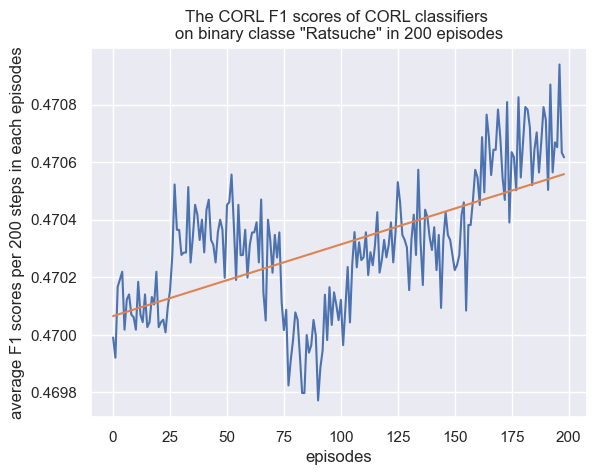

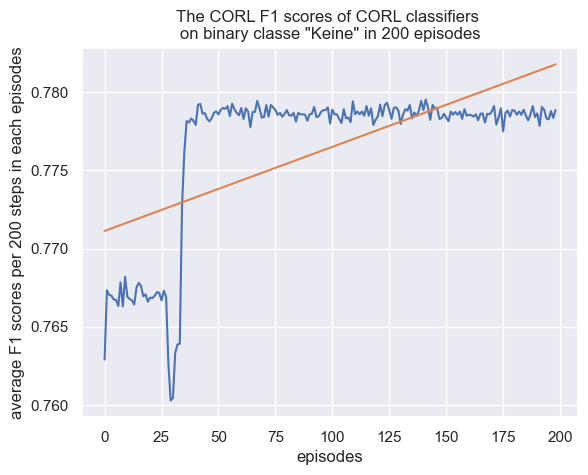

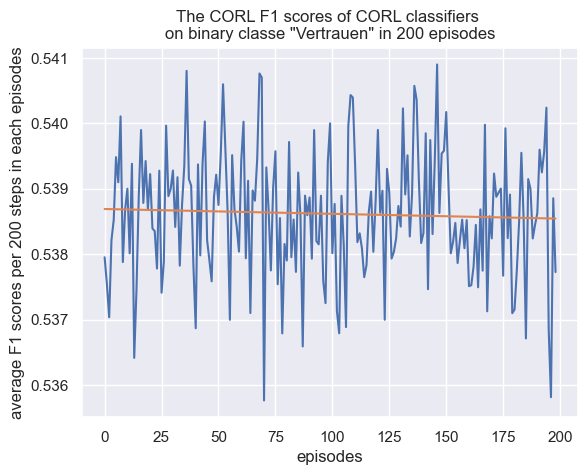

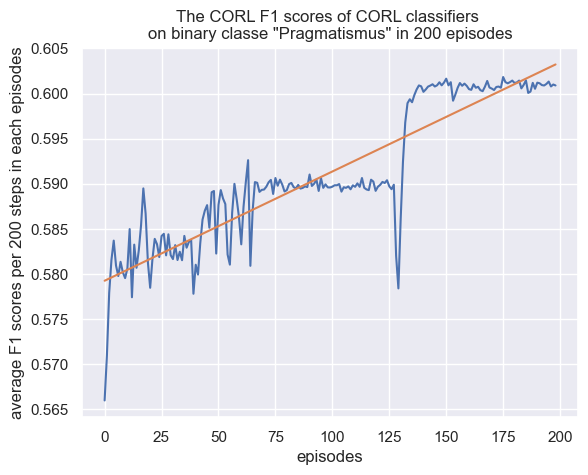

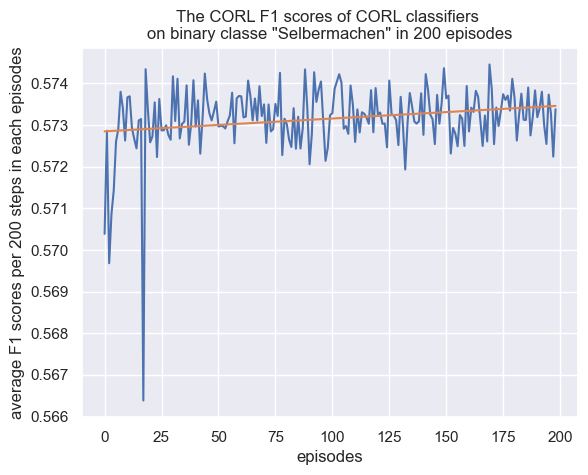

In [29]:
# plot the f1 scores

def calculate_averages(numbers):
  """Calculates the average of every 10 consecutive numbers in a list.

  Args:
    numbers: A list of numbers.

  Returns:
    A list of averages, each representing the average of 10 consecutive numbers.
  """

  averages = []
  for i in range(0, len(numbers), 200):
    chunk = numbers[i:i+200]
    average = sum(chunk) / len(chunk)
    averages.append(average)
  return averages




for i in range(5):
  # # Example usage:
  # my_list = [1, 2, 3, ..., 200]  # Replace with your actual list of 200 numbers
  result = results[i][1]
  result = calculate_averages(result)
  # print(result)



  sns.set()

  plt.plot(result)
  plt.ylabel('average F1 scores per 200 steps in each episodes')
  plt.xlabel('episodes')
  plt.title(f'The CORL F1 scores of CORL classifiers \non binary classe "{unique_labels[i]}" in {num_episodes} episodes')

  reg = LinearRegression().fit(np.arange(len(result)).reshape(-1, 1), np.array(result).reshape(-1, 1))
  y_pred = reg.predict(np.arange(len(result)).reshape(-1, 1))
  plt.plot(y_pred)
  plt.show()

In [30]:
for i in range(5):
    print(envs[i].get_f1())

(0.5263034012004236, 0.84472049689441)
(0.35992578849721707, 0.5341614906832298)
(0.5142241379310345, 0.8260869565217391)
(0.4797619047619048, 0.7639751552795031)
(0.5688405797101449, 0.7888198757763976)
